Creating a term-document matrix with which to compare each individual question.

Currently only using the dot product. Also look at cosine similarity and Jaccard index.

## Imports

In [1]:
%matplotlib inline

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
plt.style.use('ggplot')

## Functions

In [3]:
def tdm(words_unique, words_questions):
    """Create a term document matrix.
    Return the m (unique words, sorted) by n (words_questions)
    matrix, M.
    """
    M = np.zeros([len(words_unique), len(words_questions)])
    for m, term in enumerate(words_unique):
        for n, doc in enumerate(words_questions):
            M[m, n] = doc.count(term)
    return M

In [4]:
def flatten_words(list1d, get_unique=False):
    qa = [s.split() for s in list1d]
    if get_unique:
        return sorted(list(set([w for sent in qa for w in sent])))
    else:
        return [w for sent in qa for w in sent]

In [5]:
def jitter(values, sd=0.25):
    return [np.random.normal(v, sd) for v in values]

## Data

### Load

In [6]:
df = pd.read_csv('../data/newtrain.csv')

In [7]:
df.head()

,Category,Text
0,5,why are yawns contagious? when people yawn
1,6,what is trans fat? how to reduce that? i heard...
2,1,roth ira vs 401k? what is the difference betwe...
3,1,how many planes fedex has? i heard that it is ...
4,2,what is the best photo slideshow creation appl...


### Clean

Remove non-alpha numeric characters and extra whitespace.

In [10]:
df['text_clean'] = df['Text'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x.lower()))\
                             .apply(lambda x: re.sub('\s+', ' ', x).strip())

### NumPy Arrays

Get a list of *all* unique words, then create a term document matrix for each *category*.

In [11]:
words_unique_all = flatten_words(df.text_clean.values, get_unique=True)

In [12]:
words_unique_all[-5:]

['zodiac', 'zoe', 'zones', 'zoology', 'zwick']

Construct a list of lists: One list for each class.

In [13]:
df_ql = df.copy()

In [14]:
df_ql = df_ql[['Category', 'text_clean']]

In [15]:
df_ql['all_questions'] = df_ql.apply(lambda row:
                                     df.groupby('Category').get_group(row['Category'])['text_clean'].tolist(),
                                     axis=1)

In [16]:
df_ql.drop_duplicates(subset='Category', inplace=True)
df_ql.sort(columns='Category', inplace=True)
df_ql.reset_index(drop=True, inplace=True)

In [17]:
df_ql = df_ql[['Category', 'all_questions']]

In [18]:
df_ql.all_questions

0    [roth ira vs 401k what is the difference betwe...
1    [what is the best photo slideshow creation app...
2    [what was the first dvd you ever bought what w...
3    [what is the reason for the increasing divorce...
4    [why are yawns contagious when people yawn, wh...
5    [what is trans fat how to reduce that i heard ...
6    [what is an imaginary number what is an imagin...
Name: all_questions, dtype: object

---

In [41]:
documents = []

for label in np.sort(df_ql.Category.unique()):
    tdf = df_ql[df_ql['Category'] == label]
    documents.append(flatten_words(tdf['all_questions'].values[0]))

In [44]:
M = tdm(words_unique_all, documents)

In [49]:
M.sum(axis=0)

array([ 11257.,   8560.,   6302.,   6887.,   3740.,   3909.,   3309.])

Testing: Comparing a single question (represented as a vector of word counts) to the training data matrix.

In [113]:
individual_question = df_ql[df_ql['Category'] == 3]['all_questions'].values[0][10]

In [114]:
M_test = tdm(words_unique_all, individual_question)

**FIX TDM TO NOT SET EACH WORD TO A NEW COLUMN**

In [115]:
M_test = M_test.sum(axis=1)

In [116]:
results = M.T.dot(M_test)
results

array([ 28481.,  21019.,  12049.,  19248.,   8299.,   8548.,   5797.])

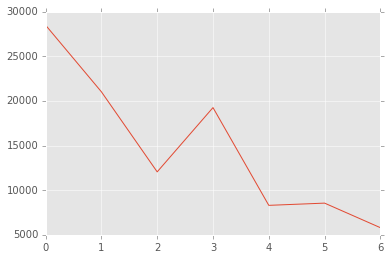

In [117]:
plt.plot(results)

What should the matrix look like? *All* unique words by category with counts in each cell?

In [44]:
example_matrix = np.array([[1, 2, 3], [2, 5, 1], [3, 3, 7], [2, 2, 2], [1, 1, 4]])

In [45]:
example_matrix

array([[1, 2, 3],
       [2, 5, 1],
       [3, 3, 7],
       [2, 2, 2],
       [1, 1, 4]])

In [46]:
example_question = np.array([3, 2, 6, 4, 2])

In [47]:
example_matrix.shape, example_question.shape

((5, 3), (5,))

In [52]:
example_matrix.T

array([[1, 2, 3, 2, 1],
       [2, 5, 3, 2, 1],
       [3, 1, 7, 2, 4]])

In [53]:
example_question

array([3, 2, 6, 4, 2])

In [51]:
example_matrix.T.dot(example_question)

array([35, 44, 69])